# Eye State Classification Model v3.0
## Robust Training for Real-Time Drowsiness Detection

### Changes from v2 (which collapsed):
1. **Removed Focal Loss** - Using standard BCE which is more stable
2. **Simplified Augmentation** - CLAHE only during inference, standard augmentation for training
3. **Proper Class Weighting** - Single mechanism, not conflicting
4. **Validation Monitoring** - Early stopping on val_loss, not val_recall
5. **Diagnostic Outputs** - Verify model is actually learning

---
**Author**: Binomial Team  
**Date**: December 2025

## Part 1: Setup

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Flatten, Dropout, Input, Add, Activation, Layer
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

2025-12-20 14:36:03.058913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766241363.253378      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766241363.308094      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766241363.752885      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766241363.752924      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766241363.752927      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# ============================================
# CONFIGURATION - SIMPLIFIED & ROBUST
# ============================================

DATA_DIR = "/kaggle/input/eyestate-yawndrowsiness-dataset/data/eyes"

# Image settings
IMG_SIZE = (64, 64)
INPUT_SHAPE = (64, 64, 1)

# Training settings - CONSERVATIVE
BATCH_SIZE = 32  # Smaller batch for more stable gradients
EPOCHS = 30
INITIAL_LR = 0.0005  # Lower LR for stability

# Class weighting - SINGLE MECHANISM
# Weight closed eyes more heavily (safety critical)
CLASS_WEIGHTS = {0: 2.0, 1: 1.0}  # 2x penalty for missing closed eyes

# Seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Part 2: Data Loading - Standard Augmentation

**Key Change**: No custom preprocessing function during training. Just standard geometric augmentation.

In [3]:
# ============================================
# DATA GENERATORS - SIMPLIFIED
# ============================================

# Training: Standard augmentation only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Built-in brightness augmentation
    fill_mode='nearest'
)

# Validation/Test: Just rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_data = train_datagen.flow_from_directory(
    f"{DATA_DIR}/train",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

val_data = val_datagen.flow_from_directory(
    f"{DATA_DIR}/val",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_data = val_datagen.flow_from_directory(
    f"{DATA_DIR}/test",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# CRITICAL: Verify class indices
print("\n" + "="*60)
print("DATA LOADING VERIFICATION")
print("="*60)
print(f"\nClass indices: {train_data.class_indices}")
print(f"  → Class 0 = {list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(0)]}")
print(f"  → Class 1 = {list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(1)]}")
print(f"\nTraining samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Test samples: {test_data.samples}")

Found 53843 images belonging to 2 classes.
Found 17950 images belonging to 2 classes.
Found 17951 images belonging to 2 classes.

DATA LOADING VERIFICATION

Class indices: {'Close': 0, 'Open': 1}
  → Class 0 = Close
  → Class 1 = Open

Training samples: 53843
Validation samples: 17950
Test samples: 17951


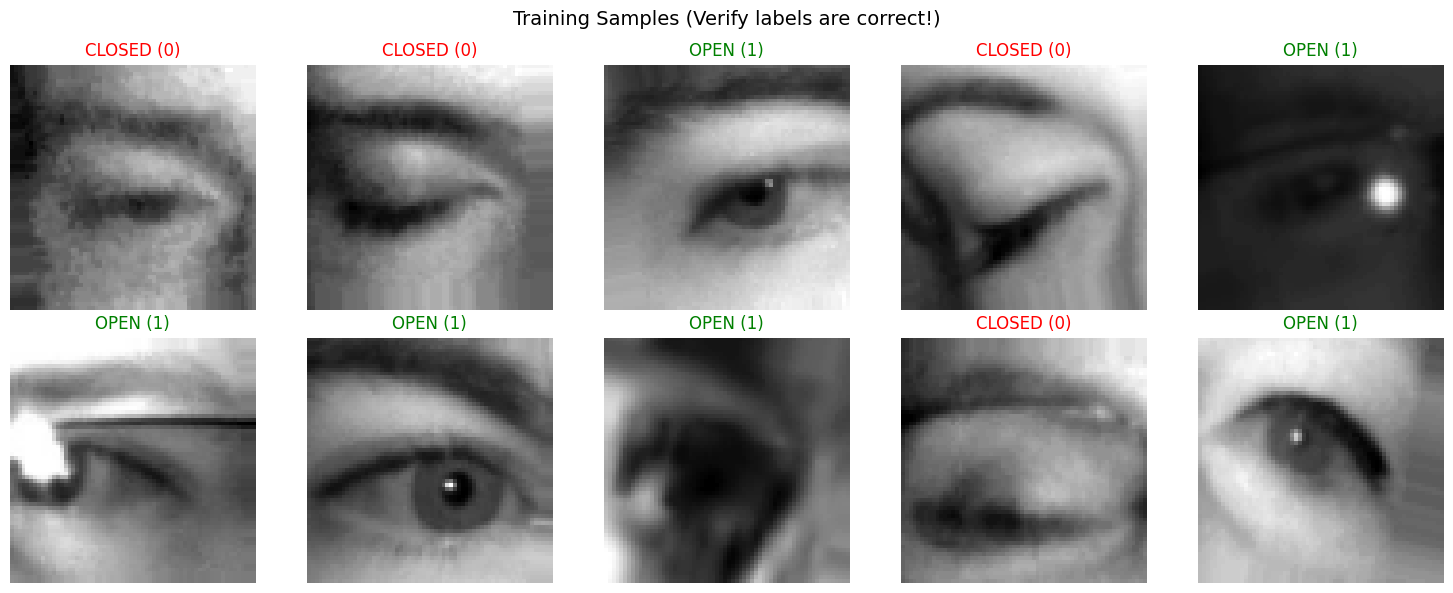

In [4]:
# Visualize some training samples to verify data looks correct
def visualize_samples():
    batch_x, batch_y = next(train_data)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Training Samples (Verify labels are correct!)', fontsize=14)
    
    for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow(batch_x[i].squeeze(), cmap='gray')
        label = 'OPEN' if batch_y[i] == 1 else 'CLOSED'
        color = 'green' if batch_y[i] == 1 else 'red'
        ax.set_title(f'{label} ({batch_y[i]:.0f})', color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('training_samples_verification.png', dpi=150)
    plt.show()

visualize_samples()
train_data.reset()

## Part 3: Model Architecture - Proven Design

In [5]:
def build_eye_classifier_v3(input_shape=(64, 64, 1)):
    """
    Robust CNN for eye state classification.
    
    Design principles:
    - Standard architecture (no fancy attention that might fail)
    - Proper regularization (dropout + batch norm)
    - Global average pooling (better generalization)
    """
    inputs = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 2
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 3
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='EyeClassifier_v3')
    return model

# Build model
model = build_eye_classifier_v3(INPUT_SHAPE)
model.summary()

I0000 00:00:1766241409.126163      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766241409.130073      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "EyeClassifier_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 313,825 (1.20 MB)

 Trainable params: 312,545 (1.19 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Part 4: Training with Monitoring

In [6]:
# Custom callback to monitor training health
class TrainingMonitor(Callback):
    """Monitor training to detect collapse early."""
    
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        train_acc = logs.get('accuracy', 0)
        
        # Warning if accuracy is near 50% (random)
        if epoch > 2 and val_acc < 0.55:
            print(f"\n⚠️  WARNING: val_accuracy={val_acc:.4f} - Model may be collapsing!")
        
        # Check for severe overfitting
        if train_acc - val_acc > 0.2:
            print(f"\n⚠️  WARNING: Overfitting detected (train-val gap = {train_acc-val_acc:.2f})")

In [7]:
# ============================================
# COMPILE - STANDARD BCE (STABLE)
# ============================================

model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='binary_crossentropy',  # Standard, stable loss
    metrics=['accuracy']
)

print(f"Optimizer: Adam (lr={INITIAL_LR})")
print(f"Loss: Binary Crossentropy")
print(f"Class weights: {CLASS_WEIGHTS}")

Optimizer: Adam (lr=0.0005)
Loss: Binary Crossentropy
Class weights: {0: 2.0, 1: 1.0}


In [8]:
# ============================================
# CALLBACKS
# ============================================

callbacks = [
    # Monitor for early stopping on val_loss (most stable)
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        mode='min',
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'eye_state_classifier_v3_best.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # Learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Custom monitoring
    TrainingMonitor()
]

print("Callbacks configured:")
print("  - EarlyStopping (patience=7, monitor=val_loss)")
print("  - ModelCheckpoint (monitor=val_accuracy)")
print("  - ReduceLROnPlateau (patience=3)")
print("  - TrainingMonitor (collapse detection)")

Callbacks configured:
  - EarlyStopping (patience=7, monitor=val_loss)
  - ModelCheckpoint (monitor=val_accuracy)
  - ReduceLROnPlateau (patience=3)
  - TrainingMonitor (collapse detection)


In [9]:
# ============================================
# TRAINING
# ============================================

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"\nExpected: Accuracy should climb above 90% within 5-10 epochs")
print(f"Warning sign: Accuracy stuck near 50% = model collapsed\n")

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)


STARTING TRAINING

Expected: Accuracy should climb above 90% within 5-10 epochs
Warning sign: Accuracy stuck near 50% = model collapsed

Epoch 1/30


I0000 00:00:1766241415.857932     150 service.cc:152] XLA service 0x7955b000a080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766241415.857976     150 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766241415.857980     150 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766241416.872705     150 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-20 14:36:59.519456: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-20 14:36:59.661521: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   1/1683 ━━━━━━━━━━━━━━━━━━━━ 6:51:04 15s/step - accuracy: 0.5312 - loss: 1.1462

I0000 00:00:1766241425.533754     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1366/1683 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.6467 - loss: 0.8803

2025-12-20 14:40:52.566545: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-20 14:40:52.707580: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6739 - loss: 0.8231
Epoch 1: val_accuracy improved from -inf to 0.91493, saving model to eye_state_classifier_v3_best.keras
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 412s 236ms/step - accuracy: 0.6740 - loss: 0.8230 - val_accuracy: 0.9149 - val_loss: 0.2292 - learning_rate: 5.0000e-04
Epoch 2/30
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9472 - loss: 0.2174
Epoch 2: val_accuracy improved from 0.91493 to 0.95833, saving model to eye_state_classifier_v3_best.keras
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 132s 78ms/step - accuracy: 0.9472 - loss: 0.2174 - val_accuracy: 0.9583 - val_loss: 0.1348 - learning_rate: 5.0000e-04
Epoch 3/30
1682/1683 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9620 - loss: 0.1591
Epoch 3: val_accuracy improved from 0.95833 to 0.98061, saving model to eye_state_classifier_v3_best.keras
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 109s 65ms/step - accuracy: 0.9620 - loss: 0.1591 - val_accuracy: 0.9806 - val_loss: 0.0710 - 

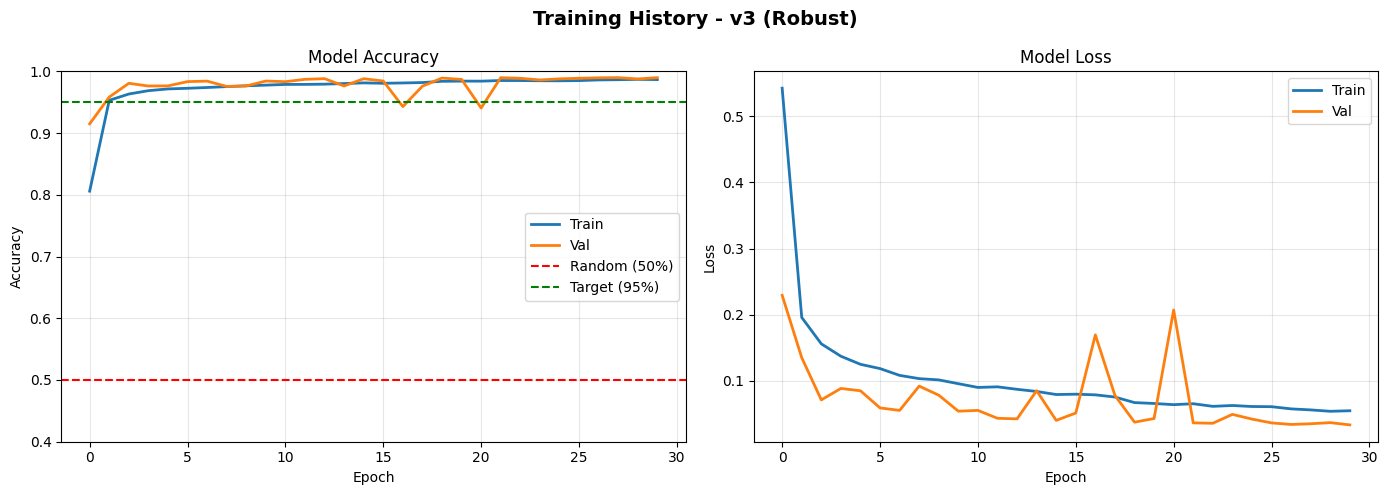


Final Training Accuracy: 98.66%
Final Validation Accuracy: 98.97%
Best Validation Accuracy: 98.98%

✅ MODEL HEALTHY: Good accuracy achieved!


In [10]:
# ============================================
# TRAINING HISTORY VISUALIZATION
# ============================================

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2)
    axes[0].axhline(y=0.5, color='r', linestyle='--', label='Random (50%)')
    axes[0].axhline(y=0.95, color='g', linestyle='--', label='Target (95%)')
    axes[0].set_title('Model Accuracy', fontsize=12)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0.4, 1.0])
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=12)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Training History - v3 (Robust)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('training_history_v3.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    
    print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
    print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
    
    # Health check
    if best_val_acc < 0.7:
        print("\n❌ MODEL FAILED: Accuracy too low. Check data/architecture.")
    elif best_val_acc < 0.9:
        print("\n⚠️  MODEL WEAK: Consider more training or architecture changes.")
    else:
        print("\n✅ MODEL HEALTHY: Good accuracy achieved!")

plot_history(history)

## Part 5: Comprehensive Evaluation

In [11]:
# ============================================
# TEST SET EVALUATION
# ============================================

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Evaluate
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Health check
if test_acc < 0.6:
    print("\n❌ CRITICAL: Model is not working. Do not deploy!")
elif test_acc < 0.9:
    print("\n⚠️  WARNING: Model needs improvement before deployment.")
else:
    print("\n✅ Model performing well!")


TEST SET EVALUATION
561/561 ━━━━━━━━━━━━━━━━━━━━ 99s 177ms/step - accuracy: 0.9897 - loss: 0.0330

Test Accuracy: 99.07%
Test Loss: 0.0321

✅ Model performing well!


561/561 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step

PREDICTION DISTRIBUTION CHECK

Prediction statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.5053
  Std: 0.4928

✅ Predictions have good variance.


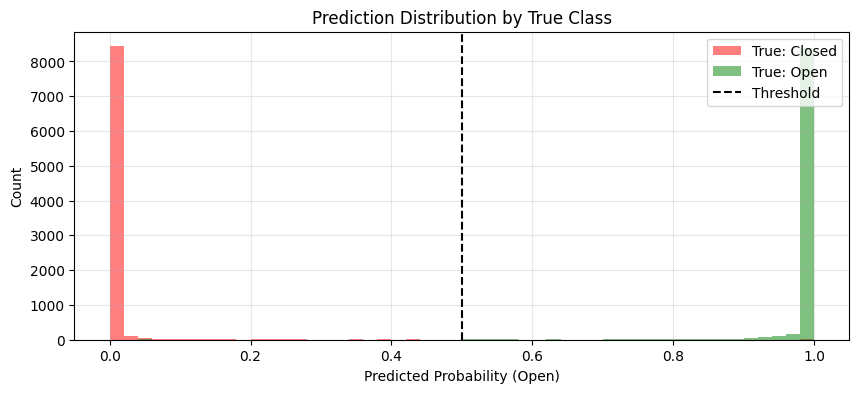

In [12]:
# ============================================
# DETAILED PREDICTIONS ANALYSIS
# ============================================

# Get predictions
test_data.reset()
y_pred_proba = model.predict(test_data, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_data.classes

# Check prediction distribution (detect collapse)
print("\n" + "="*60)
print("PREDICTION DISTRIBUTION CHECK")
print("="*60)
print(f"\nPrediction statistics:")
print(f"  Min: {y_pred_proba.min():.4f}")
print(f"  Max: {y_pred_proba.max():.4f}")
print(f"  Mean: {y_pred_proba.mean():.4f}")
print(f"  Std: {y_pred_proba.std():.4f}")

# Warning if predictions are clustered (model collapse)
if y_pred_proba.std() < 0.1:
    print("\n❌ COLLAPSE DETECTED: All predictions are nearly identical!")
    print("   Model is not discriminating between classes.")
elif y_pred_proba.std() < 0.2:
    print("\n⚠️  WARNING: Low prediction variance. Model may be underconfident.")
else:
    print("\n✅ Predictions have good variance.")

# Prediction histogram
plt.figure(figsize=(10, 4))
plt.hist(y_pred_proba[y_true == 0], bins=50, alpha=0.5, label='True: Closed', color='red')
plt.hist(y_pred_proba[y_true == 1], bins=50, alpha=0.5, label='True: Open', color='green')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
plt.xlabel('Predicted Probability (Open)')
plt.ylabel('Count')
plt.title('Prediction Distribution by True Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('prediction_distribution_v3.png', dpi=150)
plt.show()


CLASSIFICATION REPORT

Class mapping: {'Close': 0, 'Open': 1}

              precision    recall  f1-score   support

  Closed (0)       0.99      0.99      0.99      8867
    Open (1)       0.99      0.99      0.99      9084

    accuracy                           0.99     17951
   macro avg       0.99      0.99      0.99     17951
weighted avg       0.99      0.99      0.99     17951


CONFUSION MATRIX ANALYSIS

True Negatives  (Closed→Closed): 8,772 (48.9%)
True Positives  (Open→Open):     9,012 (50.2%)
False Positives (Closed→Open):   95 (0.5%) ← DANGEROUS!
False Negatives (Open→Closed):   72 (0.4%) ← False alarms

--- SAFETY METRICS ---
Closed Eye Recall:    98.93% (Target: >95%)
Closed Eye Precision: 99.19%
False Negative Rate:  1.07% (Target: <5%)


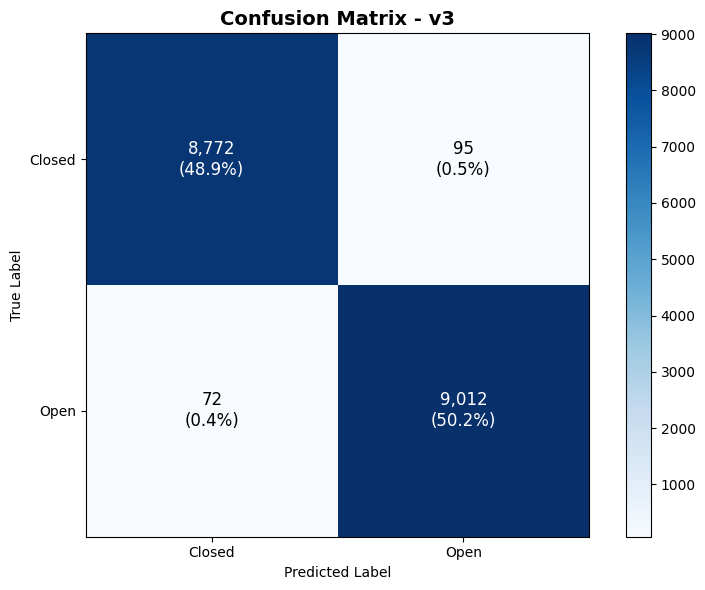

In [13]:
# ============================================
# CLASSIFICATION REPORT & CONFUSION MATRIX
# ============================================

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(f"\nClass mapping: {test_data.class_indices}")
print("\n" + classification_report(y_true, y_pred, target_names=['Closed (0)', 'Open (1)']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60)
print(f"\nTrue Negatives  (Closed→Closed): {tn:,} ({tn/total*100:.1f}%)")
print(f"True Positives  (Open→Open):     {tp:,} ({tp/total*100:.1f}%)")
print(f"False Positives (Closed→Open):   {fp:,} ({fp/total*100:.1f}%) ← DANGEROUS!")
print(f"False Negatives (Open→Closed):   {fn:,} ({fn/total*100:.1f}%) ← False alarms")

# Safety metrics
closed_recall = tn / (tn + fp) if (tn + fp) > 0 else 0
closed_precision = tn / (tn + fn) if (tn + fn) > 0 else 0
fnr = fp / (tn + fp) if (tn + fp) > 0 else 1

print(f"\n--- SAFETY METRICS ---")
print(f"Closed Eye Recall:    {closed_recall*100:.2f}% (Target: >95%)")
print(f"Closed Eye Precision: {closed_precision*100:.2f}%")
print(f"False Negative Rate:  {fnr*100:.2f}% (Target: <5%)")

# Visual
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=[0, 1], yticks=[0, 1],
       xticklabels=['Closed', 'Open'],
       yticklabels=['Closed', 'Open'],
       ylabel='True Label', xlabel='Predicted Label')

thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm[i, j]:,}\n({cm[i,j]/total*100:.1f}%)',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black', fontsize=12)

ax.set_title('Confusion Matrix - v3', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_v3.png', dpi=150)
plt.show()


THRESHOLD OPTIMIZATION

Finding optimal threshold for CLOSED eye detection...

Optimal threshold: 0.45
  Accuracy: 99.10%
  Closed Recall: 98.85%


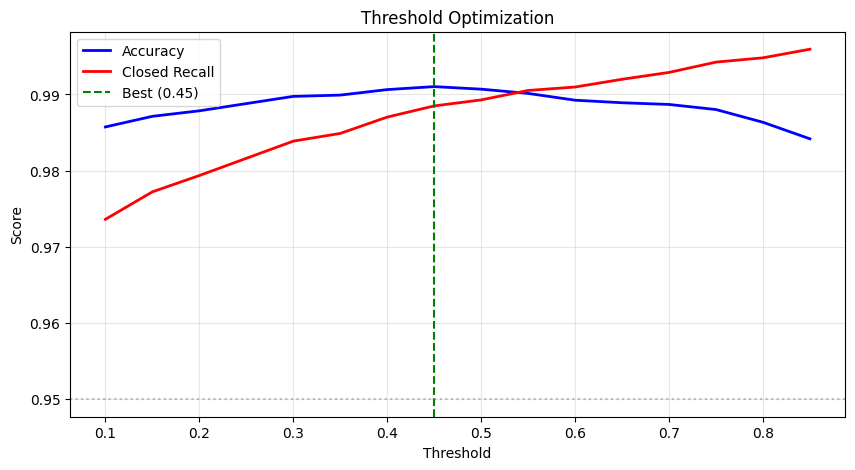

In [14]:
# ============================================
# THRESHOLD OPTIMIZATION
# ============================================

print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)
print("\nFinding optimal threshold for CLOSED eye detection...")

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_t = (y_pred_proba > thresh).astype(int).flatten()
    cm_t = confusion_matrix(y_true, y_pred_t)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
    
    acc = (tn_t + tp_t) / (tn_t + fp_t + fn_t + tp_t)
    closed_rec = tn_t / (tn_t + fp_t) if (tn_t + fp_t) > 0 else 0
    
    results.append({
        'threshold': thresh,
        'accuracy': acc,
        'closed_recall': closed_rec
    })

# Find best threshold for >95% closed recall
best = None
for r in results:
    if r['closed_recall'] >= 0.95 and r['accuracy'] >= 0.85:
        if best is None or r['accuracy'] > best['accuracy']:
            best = r

# If no threshold meets criteria, find best overall
if best is None:
    best = max(results, key=lambda x: x['closed_recall'] * 0.7 + x['accuracy'] * 0.3)

print(f"\nOptimal threshold: {best['threshold']:.2f}")
print(f"  Accuracy: {best['accuracy']*100:.2f}%")
print(f"  Closed Recall: {best['closed_recall']*100:.2f}%")

# Plot threshold analysis
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([r['threshold'] for r in results], [r['accuracy'] for r in results], 
        'b-', linewidth=2, label='Accuracy')
ax.plot([r['threshold'] for r in results], [r['closed_recall'] for r in results], 
        'r-', linewidth=2, label='Closed Recall')
ax.axvline(x=best['threshold'], color='green', linestyle='--', label=f"Best ({best['threshold']:.2f})")
ax.axhline(y=0.95, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Optimization')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('threshold_analysis_v3.png', dpi=150)
plt.show()

OPTIMAL_THRESHOLD = best['threshold']

## Part 6: Save Model

In [15]:
# ============================================
# SAVE MODEL
# ============================================

# Save in multiple formats
model.save('eye_state_classifier_v3.keras')
print("Saved: eye_state_classifier_v3.keras")

model.save('eye_state_classifier_v3.h5')
print("Saved: eye_state_classifier_v3.h5")

model.save_weights('eye_state_classifier_v3_weights.weights.h5')
print("Saved: eye_state_classifier_v3_weights.weights.h5")

print("\n✅ Model export complete!")

Saved: eye_state_classifier_v3.keras
Saved: eye_state_classifier_v3.h5
Saved: eye_state_classifier_v3_weights.weights.h5

✅ Model export complete!


In [16]:
# ============================================
# INFERENCE SPEED TEST
# ============================================

import time

dummy_input = np.random.rand(1, 64, 64, 1).astype(np.float32)

# Warm up
for _ in range(10):
    _ = model.predict(dummy_input, verbose=0)

# Benchmark
n_iterations = 100
start_time = time.time()
for _ in range(n_iterations):
    _ = model.predict(dummy_input, verbose=0)
end_time = time.time()

avg_time_ms = (end_time - start_time) / n_iterations * 1000

print("\n" + "="*60)
print("INFERENCE SPEED TEST")
print("="*60)
print(f"\nAverage inference time: {avg_time_ms:.2f} ms")
print(f"Target: <50ms " + ("✅" if avg_time_ms < 50 else "⚠️"))


INFERENCE SPEED TEST

Average inference time: 56.23 ms
Target: <50ms ⚠️


In [17]:
# ============================================
# FINAL SUMMARY
# ============================================

print("\n" + "="*70)
print("                    MODEL V3 TRAINING SUMMARY")
print("="*70)

print(f"""
ARCHITECTURE:
  - Model: EyeClassifier_v3 (Robust CNN)
  - Input: {INPUT_SHAPE}
  - Parameters: {model.count_params():,}

TRAINING:
  - Loss: Binary Crossentropy (stable)
  - Class Weights: {CLASS_WEIGHTS}
  - Epochs: {len(history.history['loss'])}
  - Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%

TEST PERFORMANCE:
  - Accuracy: {test_acc*100:.2f}%
  - Closed Eye Recall: {closed_recall*100:.2f}%
  - False Negative Rate: {fnr*100:.2f}%

DEPLOYMENT:
  - Optimal Threshold: {OPTIMAL_THRESHOLD:.2f}
  - Inference Time: {avg_time_ms:.2f}ms
  - Use with: main_v3.py
""")

# Health assessment
if test_acc > 0.95 and closed_recall > 0.95:
    print("\n✅ MODEL READY FOR DEPLOYMENT")
elif test_acc > 0.90:
    print("\n⚠️  MODEL ACCEPTABLE - Consider further optimization")
else:
    print("\n❌ MODEL NEEDS IMPROVEMENT - Do not deploy")

print("\n" + "="*70)


                    MODEL V3 TRAINING SUMMARY

ARCHITECTURE:
  - Model: EyeClassifier_v3 (Robust CNN)
  - Input: (64, 64, 1)
  - Parameters: 313,825

TRAINING:
  - Loss: Binary Crossentropy (stable)
  - Class Weights: {0: 2.0, 1: 1.0}
  - Epochs: 30
  - Best Val Accuracy: 98.98%

TEST PERFORMANCE:
  - Accuracy: 99.07%
  - Closed Eye Recall: 98.93%
  - False Negative Rate: 1.07%

DEPLOYMENT:
  - Optimal Threshold: 0.45
  - Inference Time: 56.23ms
  - Use with: main_v3.py


✅ MODEL READY FOR DEPLOYMENT



## Part 7: Visualize Sample Predictions

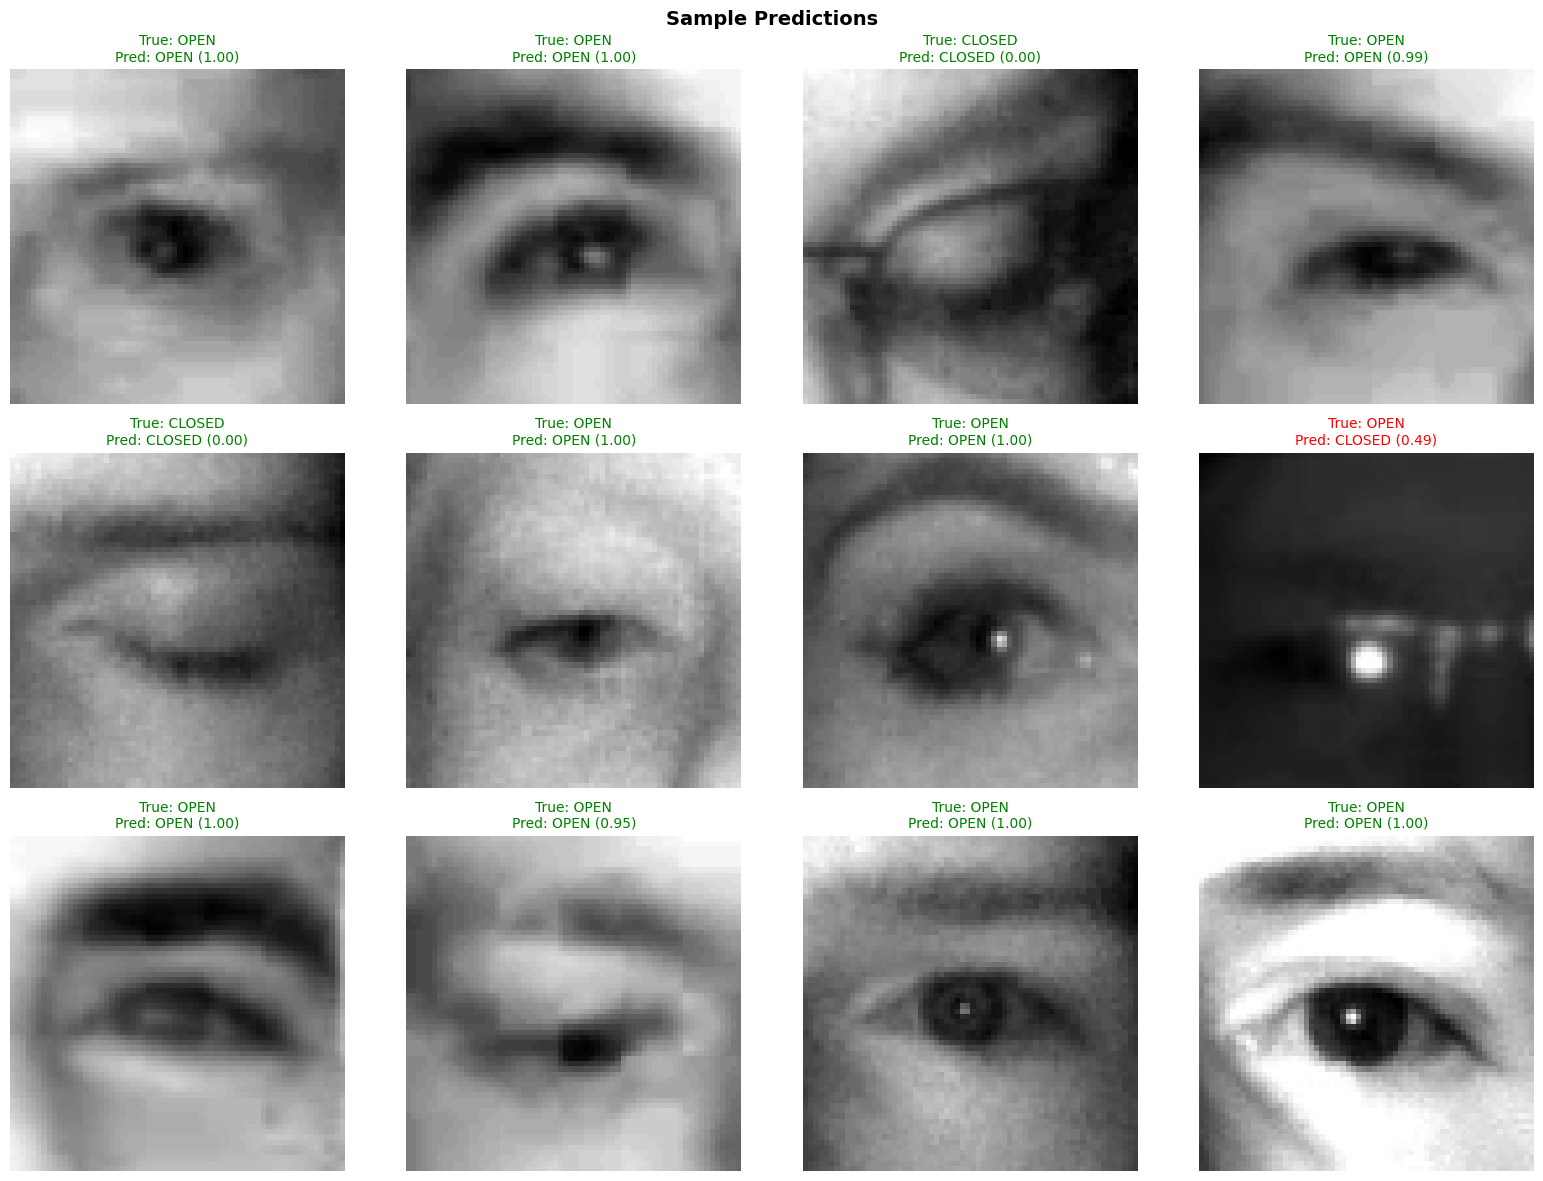

In [18]:
# ============================================
# VISUALIZE PREDICTIONS
# ============================================

def visualize_predictions(test_data, y_true, y_pred, y_pred_proba, n_samples=12):
    """Show sample predictions."""
    test_data.reset()
    
    # Get all images
    all_images = []
    for _ in range(len(test_data)):
        batch, _ = next(test_data)
        all_images.extend(batch)
    all_images = np.array(all_images)
    
    # Random selection
    indices = np.random.choice(len(y_true), n_samples, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Sample Predictions', fontsize=14, fontweight='bold')
    
    for i, idx in enumerate(indices):
        ax = axes[i // 4, i % 4]
        ax.imshow(all_images[idx].squeeze(), cmap='gray')
        
        true_label = 'OPEN' if y_true[idx] == 1 else 'CLOSED'
        pred_label = 'OPEN' if y_pred[idx] == 1 else 'CLOSED'
        conf = y_pred_proba[idx][0]
        
        correct = y_true[idx] == y_pred[idx]
        color = 'green' if correct else 'red'
        
        ax.set_title(f'True: {true_label}\nPred: {pred_label} ({conf:.2f})', 
                     color=color, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions_v3.png', dpi=150)
    plt.show()

visualize_predictions(test_data, y_true, y_pred, y_pred_proba)